In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import io
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)
# Гиперпараметры
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10

# Выбор устройства для вычислений
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [1]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# 1. Простая CNN архитектура вместо ResNet
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # 224/2/2/2=28
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        return x

# 2. Новая Siamese сеть с простым энкодером
class SimpleSiamese(nn.Module):
    def __init__(self):
        super(SimpleSiamese, self).__init__()
        self.encoder = SimpleCNN()
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),  # 256*2=512
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1))
        
    def forward(self, img1, img2):
        feat1 = self.encoder(img1)
        feat2 = self.encoder(img2)
        combined = torch.cat((feat1, feat2), dim=1)
        return self.classifier(combined)

In [5]:
class ImagePairDataset(Dataset):
    """
    Класс Dataset для загрузки и предобработки пар изображений.
    """
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Получаем строку из DataFrame по индексу
        row = self.dataframe.iloc[idx]

        # Декодируем байты в изображения
        # io.BytesIO создает в памяти файлоподобный объект из байтовой строки
        try:
            image1 = Image.open(io.BytesIO(row['image_1'])).convert('RGB')
            image2 = Image.open(io.BytesIO(row['image_2'])).convert('RGB')
        except Exception as e:
            print(f"Ошибка загрузки изображения по индексу {idx}: {e}")
            # В реальном проекте здесь может быть логика для возврата "пустого" тензора
            raise

        # Применяем трансформации, если они заданы
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        # Метка: 1.0, если первое изображение лучше, иначе 0.0
        label = torch.tensor([float(row['is_image1_better'])], dtype=torch.float32)

        return image1, image2, label


Пример данных из обучающего набора (df_train):


,image_1,image_2,is_image1_better
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'RIFF\x06%\x01\x00WEBPVP8 \xfa$\x01\x00\xb0A\...,1
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'RIFFL\x99\x01\x00WEBPVP8 @\x99\x01\x00p\xbb\...,0
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"b'RIFF8@\x02\x00WEBPVP8 ,@\x02\x00\x106\t\x9d\...",1
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'RIFFv\n\x01\x00WEBPVP8 j\n\x01\x00p\xbe\x04\...,0
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'RIFF\xde|\x00\x00WEBPVP8 \xd2|\x00\x00PH\x03...,0



Пример первого изображения из первой строки:


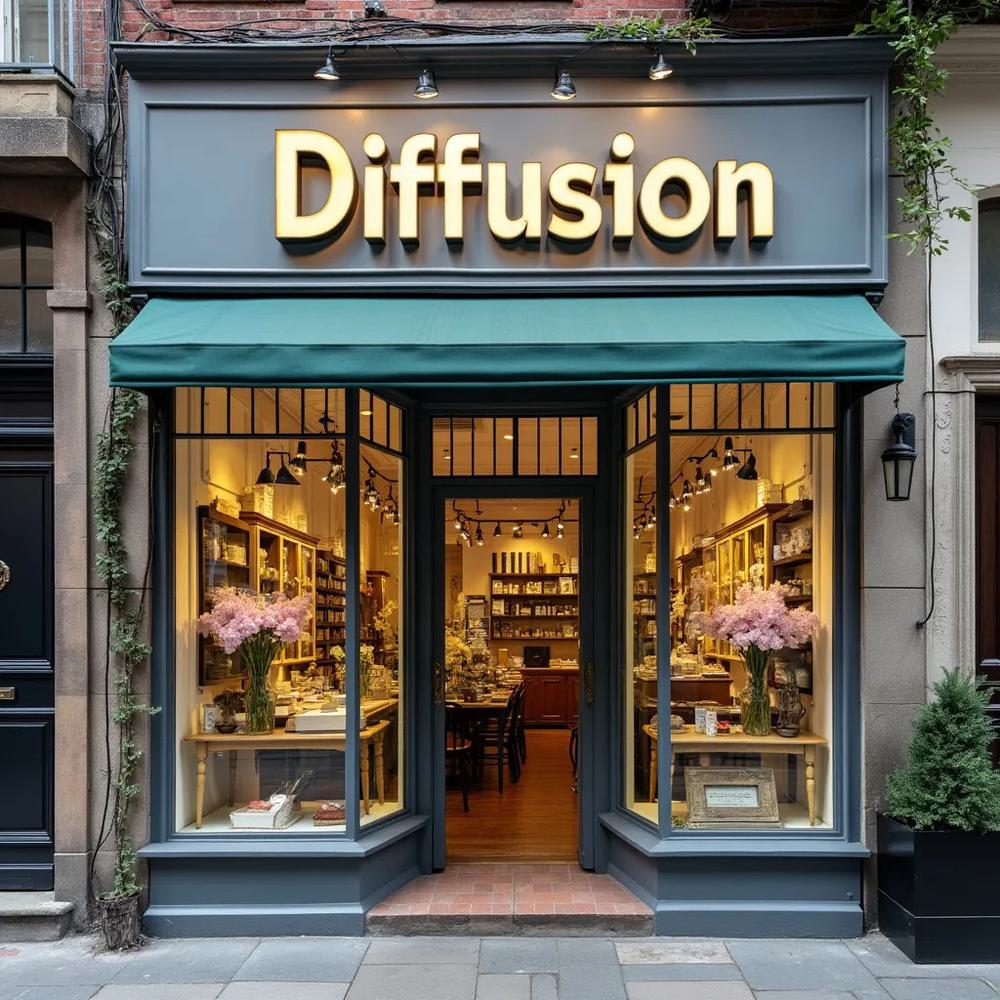

In [6]:
df_train = pd.read_parquet('train.parquet')
print("\nПример данных из обучающего набора (df_train):")
display(df_train.head())

# Посмотрим на одно из сгенерированных изображений
print("\nПример первого изображения из первой строки:")
display(Image.open(io.BytesIO(df_train.iloc[0]['image_1'])))

In [8]:
# 1. Определяем трансформации для изображений
df_test = pd.read_parquet('test.parquet')
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Разделение данных на train/val
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)
train_dataset = ImagePairDataset(train_df, transform=data_transforms)
val_dataset = ImagePairDataset(val_df, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Инициализируем модель, функцию потерь и оптимизатор
model = SimpleSiamese().to(device)

# BCEWithLogitsLoss численно более стабильна, чем Sigmoid + BCELoss
criterion = nn.BCEWithLogitsLoss()

# Adam - хороший выбор для большинства задач
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train() # Переводим модель в режим обучения
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images1, images2, labels in tqdm(dataloader, desc="Обучение"):
        # Перемещаем данные на нужное устройство
        images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images1, images2) # Прямой проход
        loss = criterion(outputs, labels) # Вычисление ошибки
        
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Обновление весов
        
        # Собираем статистику
        running_loss += loss.item() * images1.size(0)
        # Превращаем логиты в предсказания (0 или 1)
        preds = torch.sigmoid(outputs) > 0.5
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_model(model, dataloader, criterion, device):
    model.eval() # Переводим модель в режим оценки
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Списки для хранения всех предсказаний и меток
    all_preds_logits = []
    all_labels = []

    with torch.no_grad(): # Отключаем расчет градиентов
        for images1, images2, labels in tqdm(dataloader, desc="Оценка"):
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
            
            outputs = model(images1, images2)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images1.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
            # Сохраняем логиты и метки для расчета ROC-AUC
            all_preds_logits.append(outputs.cpu())
            all_labels.append(labels.cpu())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    
    # Объединяем результаты со всех батчей
    all_preds_logits = torch.cat(all_preds_logits)
    all_labels = torch.cat(all_labels)
    
    return epoch_loss, epoch_acc, all_preds_logits, all_labels

In [10]:
# 5. Обучение с валидацией
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    # Обучение
    model.train()
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    
    # Валидация
    val_loss, val_acc, val_logits, val_labels = evaluate_model(model, val_loader, criterion, device)
    val_auc = roc_auc_score(val_labels.numpy(), torch.sigmoid(val_logits).numpy())
    
    print(f"Эпоха {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 1/10 | Train Loss: 0.6554 | Train Acc: 0.6527 | Val Loss: 0.6522 | Val Acc: 0.6435 | Val AUC: 0.5313


Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 2/10 | Train Loss: 0.6471 | Train Acc: 0.6554 | Val Loss: 0.6470 | Val Acc: 0.6435 | Val AUC: 0.5544


Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 3/10 | Train Loss: 0.6386 | Train Acc: 0.6554 | Val Loss: 0.6480 | Val Acc: 0.6435 | Val AUC: 0.5865


Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 4/10 | Train Loss: 0.6290 | Train Acc: 0.6564 | Val Loss: 0.6396 | Val Acc: 0.6429 | Val AUC: 0.5998


Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 5/10 | Train Loss: 0.6070 | Train Acc: 0.6665 | Val Loss: 0.6321 | Val Acc: 0.6567 | Val AUC: 0.6225


Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 6/10 | Train Loss: 0.5765 | Train Acc: 0.6989 | Val Loss: 0.6455 | Val Acc: 0.6475 | Val AUC: 0.6117


Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 7/10 | Train Loss: 0.5320 | Train Acc: 0.7232 | Val Loss: 0.6485 | Val Acc: 0.6533 | Val AUC: 0.6166


Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 8/10 | Train Loss: 0.4765 | Train Acc: 0.7668 | Val Loss: 0.7149 | Val Acc: 0.6447 | Val AUC: 0.6091


Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 9/10 | Train Loss: 0.4151 | Train Acc: 0.8100 | Val Loss: 0.7414 | Val Acc: 0.6441 | Val AUC: 0.5965


Обучение:   0%|          | 0/436 [00:00<?, ?it/s]

Оценка:   0%|          | 0/109 [00:00<?, ?it/s]

Эпоха 10/10 | Train Loss: 0.3697 | Train Acc: 0.8345 | Val Loss: 0.8780 | Val Acc: 0.6378 | Val AUC: 0.5788


In [13]:
# 6. Подбор оптимального порога по валидации
val_probs = torch.sigmoid(val_logits).numpy()
fpr, tpr, thresholds = roc_curve(val_labels.numpy(), val_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nОптимальный порог: {optimal_threshold:.4f}")



Оптимальный порог: 0.4150


In [17]:
# 1. Создаем специальный Dataset для теста (без меток)
class TestImagePairDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image1 = Image.open(io.BytesIO(row['image_1'])).convert('RGB')
        image2 = Image.open(io.BytesIO(row['image_2'])).convert('RGB')
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2  # Только изображения, без меток

# 2. Модифицированная функция predict для теста
def predict_test(model, dataloader, device):
    model.eval()
    preds_logits = []
    
    with torch.no_grad():
        for images1, images2 in dataloader:  # Теперь получаем только два элемента
            images1, images2 = images1.to(device), images2.to(device)
            outputs = model(images1, images2)
            preds_logits.append(outputs.cpu())
    
    return torch.cat(preds_logits)

# 3. Подготовка тестовых данных
test_dataset = TestImagePairDataset(df_test, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. Получение предсказаний
test_logits = predict_test(model, test_loader, device)
test_preds = (torch.sigmoid(test_logits) > optimal_threshold).int().numpy()

# 5. Сохранение результатов
results_df = pd.DataFrame({
    'index': df_test.index,
    'is_image1_better': test_preds.flatten()
})
results_df.to_csv('cv_predictions.csv', index=False)

print(f"Успешно сохранено {len(results_df)} предсказаний")
print("Распределение классов:")
print(results_df['is_image1_better'].value_counts())

Успешно сохранено 4290 предсказаний
Распределение классов:
is_image1_better
0    2981
1    1309
Name: count, dtype: int64
